In [6]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [7]:
digits = load_digits(n_class=6)
X_minst, y_minst = digits.data, digits.target
n_samples, n_features = X_minst.shape
print(X_minst[0])
print(n_samples, n_features)

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
1083 64


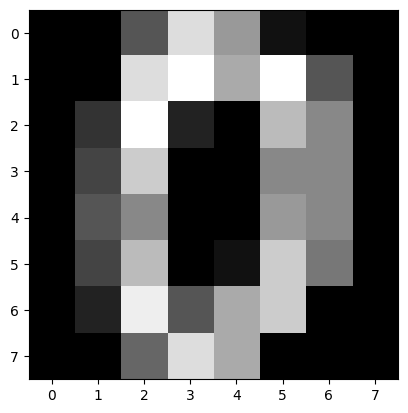

In [8]:
# reshape X[0] to a 2D array
img = np.reshape(X_minst[0], (8, 8))

# plot the image
plt.imshow(img, cmap='gray')
plt.show()


# Neighborhood Preserving Embedding (NPE)
![alt text](img/NPE_algorithm.png "Algorithm")


## Step 1: KNN

In [9]:
X = X_minst
y = y_minst

In [10]:
from sklearn.neighbors import NearestNeighbors

k = 11

def adjacency_graph(X, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', n_jobs=-1).fit(X)
    k = k - 1 #This becase the first neighbor is the point itself

    # Query for nearest neighbors
    Q_distances = []
    Q_indices = []
    for i in range(len(X)):
        distance, index = nbrs.kneighbors([X[i]])
        Q_distances.append(distance[0][1:])
        Q_indices.append(index[0][1:])
    # distances: Array of distances to the k nearest neighbors
    # indices: Array of indices of the k nearest neighbors in x_train
        
    return Q_distances, Q_indices

Q_distances, Q_indices = adjacency_graph(X, k)

## Step 2: Compute the weight matrix W


To construct the weight matrix $W \in \mathbb{R}^{m \times m}$, where the $(i+1)$-th row and $(j+1)$-th column element is $W_{ij}$, the objective function to optimize is:


$$\min \sum_{i}\Vert {\bf x}_{i}-\sum_{j}W_{ij}{\bf x}_{j}\Vert^{2}$$
with contraints $\sum_{j}W_{ij}=1,j=1,2, \ldots, m$

Let $C^{(i)}$ denote an $m x m$ matrix relatex to $x_i$, called neighborhood correlation matrix, where:

![alt text](img/formula_3.png)

Then, let $W_i$ denotes the $(i + 1)$-th row of matrix $W$, then the solution of the objective function is:

![alt text](img/formula_4.png)

In [12]:
def compute_weight_matrix(X, Q_distances, Q_indices, k):

    tol = 1e-5
    k = k - 1

    n = len(X)
    # W = np.zeros((n, n))
    W = []
    k_1 = np.ones((k))
    I = np.ones((k, 1))

    for i in range(n):
        xi = X[i]
        C = []
        for j in range(k):
            xj = X[Q_indices[i][j]]
            C_aux = []
            for m in range(k):
                xm = X[Q_indices[i][m]]
                C_jk =(xi - xj).T @ (xi - xm)
                C_aux.append(C_jk)
            C.append(C_aux)
        C = np.array(C)
        # print(C.shape)
        C = C + tol * np.eye(*C.shape) # Regularization for C
        w = np.linalg.inv(C) @ k_1
        w = w / (k_1.T @ np.linalg.inv(C) @ k_1)

        # Create an 1 x n array that will contain a 0 if xj is not a 
        # neighbour of xi, otherwise it will cointain the weight of x_j
        w_real = np.zeros((1, n))
        np.put(w_real, Q_indices[i], w)
        W.append(list(w_real[0]))

    W = np.array(W)
    return W

W = compute_weight_matrix(X, Q_distances, Q_indices, k)
print(W.shape)

(1083, 1083)


## Step 3: Computing the projections
In this step, we compute the linear projections. Solve the following generalized eigenvector problem:
$$XMX^{T}{\bf a}=\lambda XX^{T}{\bf a}$$
Where
$$\ \ X=({\bf x}_{1}, \cdots, {\bf x}_{m}) \\ M=(I-W)^{T}(I-W) \\ I=diag(1, \cdots, 1)$$
There are many different method to solve the eigenvalue problem. In this implementation, we use the method of the spectral regression (SR). \
The eigenvalue problem can be solved by two steps. \
First step: solve the following eigenvalue problem to get the bottom non-zero eigenvectors $z_{0}, z_{1}, \cdots, z_{d-1}$:
$$Mz = \lambda z$$
Second step: Find $a_i$ that satisfies 

![alt text](img/formula_8.png)

where $z_{ij}$ is the $j$-th element of $z_i$ and $\alpha >= 0$ is a regularization parameter. 


In [13]:
d = 2
alpha = 1e-5


def compute_projection_matrix(X, W, d, alpha):

    A = []
    n = len(X)
    I = np.eye(n)

    M = (I - W).T @ (I - W)

    eigvalues, eigvectors = np.linalg.eig(M)

    # Sort the eigenvalues and eigenvectors in ascending order
    index_ = np.argsort(np.abs(eigvalues))[1:d+1]
    z = eigvectors[:, index_]

    I = np.eye(X.shape[1])
    for i in range(d):
        ai = (X.T @ X) + (alpha * I)
        ai = np.linalg.inv(ai)
        ai = ai @ X.T @ z[:, i]
        A.append(ai)


    A = np.array(A).T
    return A

A = compute_projection_matrix(X, W, d, alpha)

### Transforming the data

In [14]:
A.shape

(64, 2)

In [15]:
def trasforming_data(X, A):

    x_transformed = []
    for i in range(X.shape[0]):
        x_transformed.append( A.T @ X[i])
    x_transformed = np.array(x_transformed)

    return x_transformed

x_train_transformed = trasforming_data(X, A)

# Evaluation
### MINST Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_minst, y_minst, test_size=0.25, random_state=124)

basic_classifier = KNeighborsClassifier(n_neighbors=3)
basic_classifier.fit(x_train, y_train)
predicted = basic_classifier.predict(x_test)


print("Accuracy score: ", accuracy_score(y_test, predicted))

Accuracy score:  0.996309963099631


In [17]:
import pickle
from myAlg.myPCA import myPCA, myKernelPCA
from myAlg.myISOMAP import myISOMAP
from myAlg.myLLE import lle
from sklearn.manifold import TSNE, MDS
import umap

from sklearn.metrics import silhouette_score
import time


dim = 2
DO_COMPUTATION = False



if DO_COMPUTATION:

    
    pca = myPCA()
    kernel_pca = myKernelPCA(kernel='poly', sigma=1.3)
    mds = MDS(n_components=dim, normalized_stress='auto')
    tsne = TSNE(n_components=dim, method='exact', n_jobs=-1)
    umap_embedding = umap.UMAP(n_components=dim, n_neighbors = 6)

    Q_distances, Q_indices = adjacency_graph(X, k)
    W = compute_weight_matrix(X, Q_distances, Q_indices, k)
    A = compute_projection_matrix(X, W, d, alpha)
    x_NPE = trasforming_data(X, A) # NPE
    x_NPE = np.real(x_NPE)

    x_UMAP = umap_embedding.fit_transform(X)
    x_pca = pca.fit_transform(X, dim)
    x_kernel_pca = kernel_pca.fit_transform(X, dim)
    x_mds = mds.fit_transform(X)
    x_isomap, _, _ = myISOMAP(X, n_neighbors=12, n_components=dim)
    x_lle = lle(X, n_components=dim, n_neighbors=12)
    x_tsne = tsne.fit_transform(X)

    

    list_of_transformations = [x_NPE, x_pca, x_kernel_pca, x_mds, x_isomap, x_lle, x_tsne, x_UMAP]

    with open('data/transformations_minst.pickle', 'wb') as f:
        pickle.dump(list_of_transformations, f)

else:
    with open('data/transformations_minst.pickle', 'rb') as f:
        list_of_transformations = pickle.load(f)


list_of_names = ["NPE", "PCA", "Kernel PCA", "MDS", "Isomap", "LLE", "t-SNE", "UMAP"]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(1083, 1083)
[1.0039550182910599e-16, 1.7379486531009127e-09, 2.858479589880059e-07, 1.193605361167241e-06, 3.1903464588891004e-06, 5.761923413917459e-06, 1.0247596217806873e-05, 1.8574665653096895e-05, 0.00012146262393139594, 0.00016936132220404072, 0.0003051555834095247, 0.00030730023480074513, 0.0003329390706738522, 0.0003487549899772422, 0.0005079066917325491, 0.0007866861830793057, 0.0009582020932642632, 0.0010041228425426445, 0.0011477817035411078, 0.0011623895246417422, 0.0012567974240622023, 0.0013157917455662517, 0.0013865057796242572, 0.0016513134971121858, 0.0016891591730276035, 0.001995178546162504, 0.002140257198804228, 0.0022275974068715976, 0.0024132821072253563, 0.0025683245239820694, 0.0028681821251239224, 0.003030075885184089, 0.0031603249150096943, 0.0035652235001937854, 0.0038134927643671294, 0.0041050912602584345, 0.004296343094074206, 0.004500886949316905, 0.004717456646287989, 0.004815079985398926, 0.005291109909272519, 0.005522120413285795, 0.0057834095103338, 0

In [18]:
# RUN ONLY IF WE USE THE MINST DATASET

print("Number of dimension: ", dim)
acc = []
sil = []
i=0



for x_trans in list_of_transformations:

    print(list_of_names[i])
    x_train, x_test, y_train, y_test = train_test_split(x_trans, y, test_size=0.3, random_state=124)
    basic_classifier = KNeighborsClassifier(n_neighbors=3)
    basic_classifier.fit(x_train, y_train)
    predicted = basic_classifier.predict(x_test)

    print("Accuracy: ", round(accuracy_score(y_test, predicted), 3))
    print("silhouette_score: ", silhouette_score(x_trans, y))
    acc.append(accuracy_score(y_test, predicted))
    sil.append(silhouette_score(x_trans, y))
    i+=1

Number of dimension:  2
NPE
Accuracy:  0.862
silhouette_score:  0.38714533396543155
PCA
Accuracy:  0.831
silhouette_score:  0.3262671756345313
Kernel PCA
Accuracy:  0.834
silhouette_score:  0.3272456064533953
MDS
Accuracy:  0.889
silhouette_score:  0.2786711050168225
Isomap
Accuracy:  0.969
silhouette_score:  0.4347836012013218
LLE
Accuracy:  0.985
silhouette_score:  0.6908370405371933
t-SNE
Accuracy:  0.994
silhouette_score:  0.66860527
UMAP
Accuracy:  0.994
silhouette_score:  0.7628823


Time for NPE :  0.021\
Time for PCA :  0.018\
Time for Kernel PCA :  0.018\
Time for MDS :  0.02\
Time for Isomap :  0.014\
Time for LLE :  0.016\
Time for t-SNE :  0.014\
<!-- Time for Spectral Embedding :  0.014\ -->

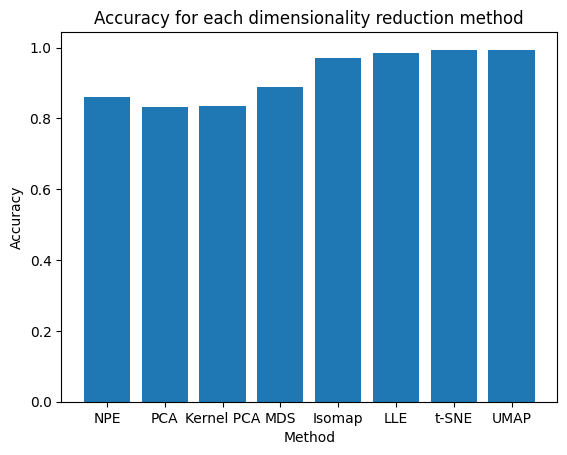

In [19]:
plt.bar(list_of_names, acc)
plt.title("Accuracy for each dimensionality reduction method")
plt.xlabel("Method")
plt.ylabel("Accuracy")
# plt.ylim(0.98, 1.00)
plt.show()


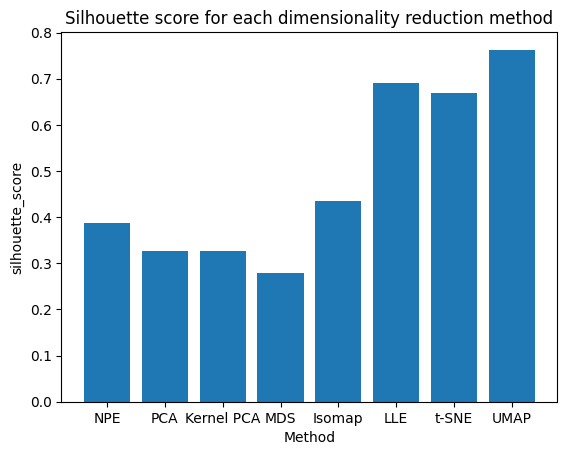

In [20]:
plt.bar(list_of_names, sil)
plt.title("Silhouette score for each dimensionality reduction method")
plt.xlabel("Method")
plt.ylabel("silhouette_score")
plt.show()

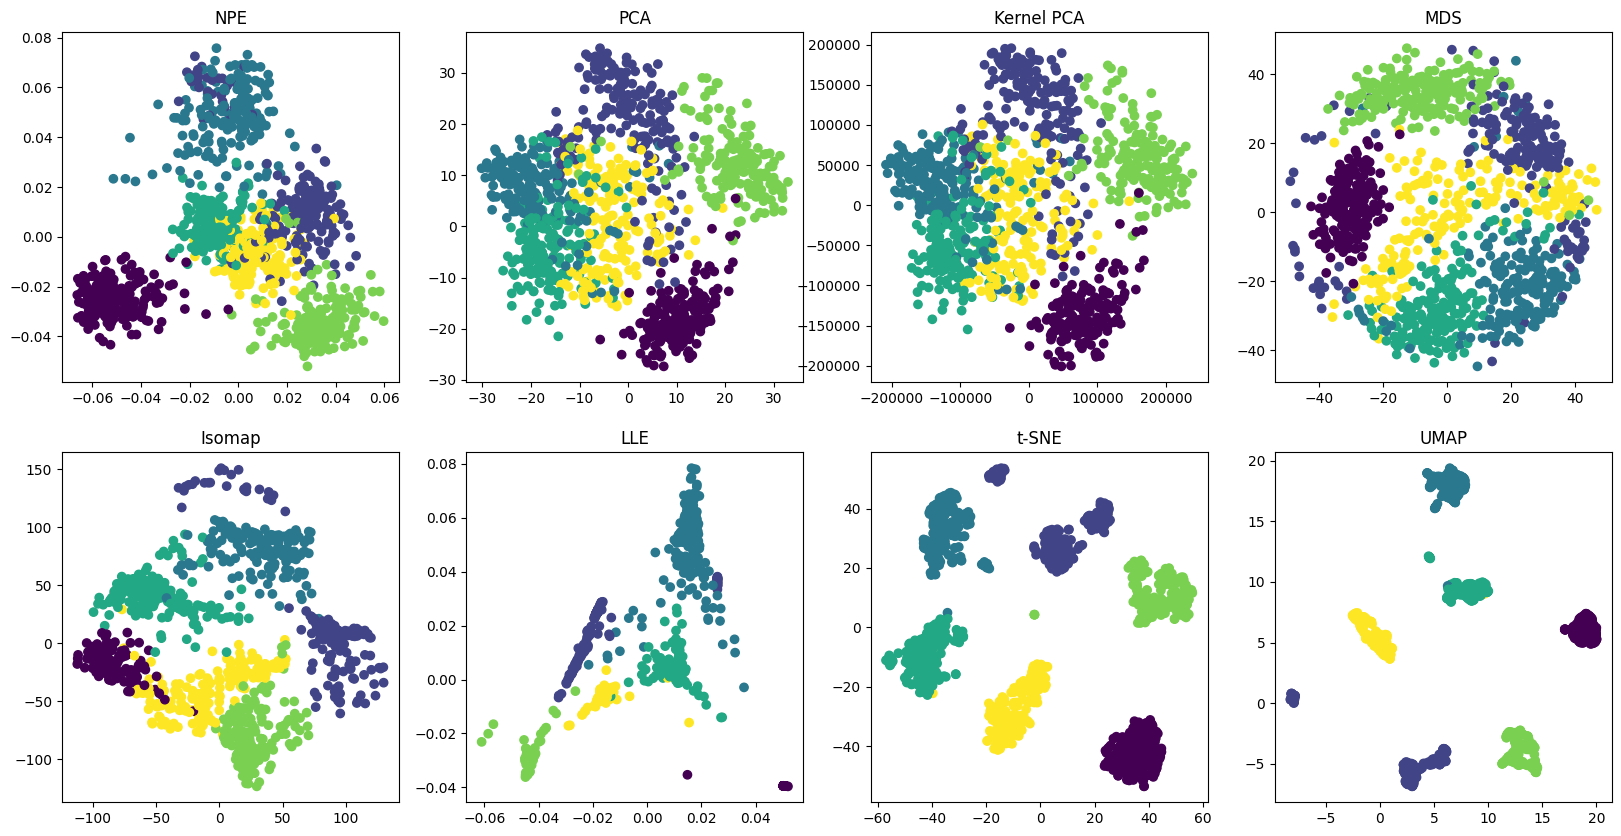

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for i, (transformation, name) in enumerate(zip(list_of_transformations, list_of_names)):
    axs[i].scatter(transformation[:, 0], transformation[:, 1], c=y)
    axs[i].set_title(name)

plt.show()


### Swiss roll dataset

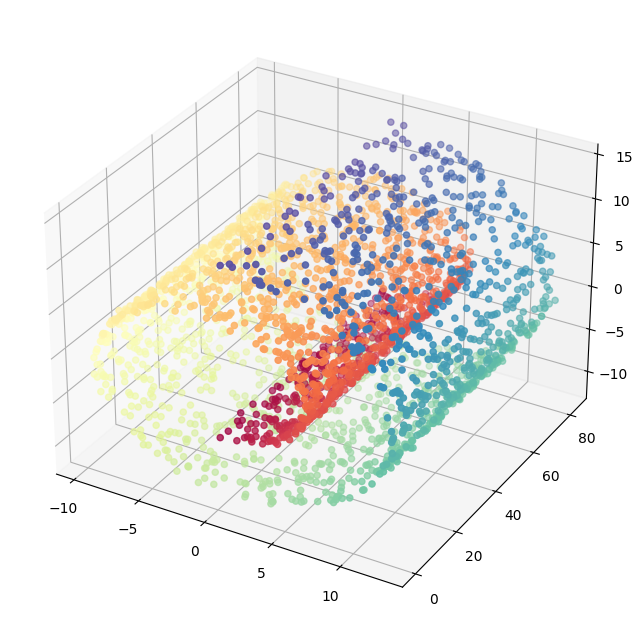

In [24]:
def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

X_swiss, Y_swiss = make_swiss_roll(n_samples = 3000, noise=0.1, random_state=42)

plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=Y_swiss, cmap=plt.cm.Spectral)
plt.show()

In [27]:
import pickle
from myAlg.myPCA import myPCA, myKernelPCA
from myAlg.myISOMAP import myISOMAP
from myAlg.myLLE import lle
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE, MDS
import umap

from sklearn.metrics import silhouette_score
import time

X = X_swiss
y = Y_swiss

dim = 2
DO_COMPUTATION = True
sigma=1.3


if DO_COMPUTATION:

    
    pca = myPCA()
    kernel_pca = KernelPCA(kernel='poly', gamma=1/(2*sigma**2), n_components=dim)
    mds = MDS(n_components=dim, normalized_stress='auto')
    tsne = TSNE(n_components=dim, method='exact', n_jobs=-1)
    umap_embedding = umap.UMAP(n_components=dim, n_neighbors = 6)

    Q_distances, Q_indices = adjacency_graph(X, k)
    W = compute_weight_matrix(X, Q_distances, Q_indices, k)
    A = compute_projection_matrix(X, W, d, alpha)
    x_NPE = trasforming_data(X, A) # NPE
    x_NPE = np.real(x_NPE)

    x_UMAP = umap_embedding.fit_transform(X)
    x_pca = pca.fit_transform(X, dim)
    x_kernel_pca = kernel_pca.fit_transform(X)
    x_mds = mds.fit_transform(X)
    x_isomap, _, _ = myISOMAP(X, n_neighbors=12, n_components=dim)
    x_lle = lle(X, n_components=dim, n_neighbors=12)
    x_tsne = tsne.fit_transform(X)

    

    list_of_transformations = [x_NPE, x_pca, x_kernel_pca, x_mds, x_isomap, x_lle, x_tsne, x_UMAP]

    with open('data/transformations_swiss.pickle', 'wb') as f:
        pickle.dump(list_of_transformations, f)

else:
    with open('data/transformations_swiss.pickle', 'rb') as f:
        list_of_transformations = pickle.load(f)


list_of_names = ["NPE", "PCA", "Kernel PCA", "MDS", "Isomap", "LLE", "t-SNE", "UMAP"]

(3000, 3000)
[5.651500788991188e-16, 9.0872936755702e-16, 1.0202019634863011e-14, 2.371933652776583e-14, 2.9718616518584785e-12, 8.899172336564527e-12, 1.0233077307033262e-10, 1.4851885189626153e-10, 6.64714408060274e-10, 2.39645390657087e-09, 1.0460478080800252e-08, 2.231170357131389e-08, 4.242773376161256e-08, 5.855168088217547e-08, 1.0642293880868946e-07, 1.661049996021099e-07, 2.858429200509933e-07, 3.060793118909002e-07, 4.138760614520078e-07, 7.151231271814104e-07, 9.280420762910659e-07, 1.0332047540286172e-06, 1.3356596468464012e-06, 1.6597673626994978e-06, 1.8765329161896548e-06, 2.160109706163818e-06, 2.3476517159069583e-06, 2.745856715112366e-06, 3.500041452819819e-06, 4.090841021128775e-06, 5.444259515343653e-06, 7.699683478972045e-06, 7.876055481093082e-06, 1.0002653768813271e-05, 1.042962581411783e-05, 1.1272999208277435e-05, 1.5213512378340944e-05, 1.573309143970979e-05, 1.616511190419463e-05, 2.0645102342062782e-05, 2.1675836736233813e-05, 2.5865394941928262e-05, 2.92132

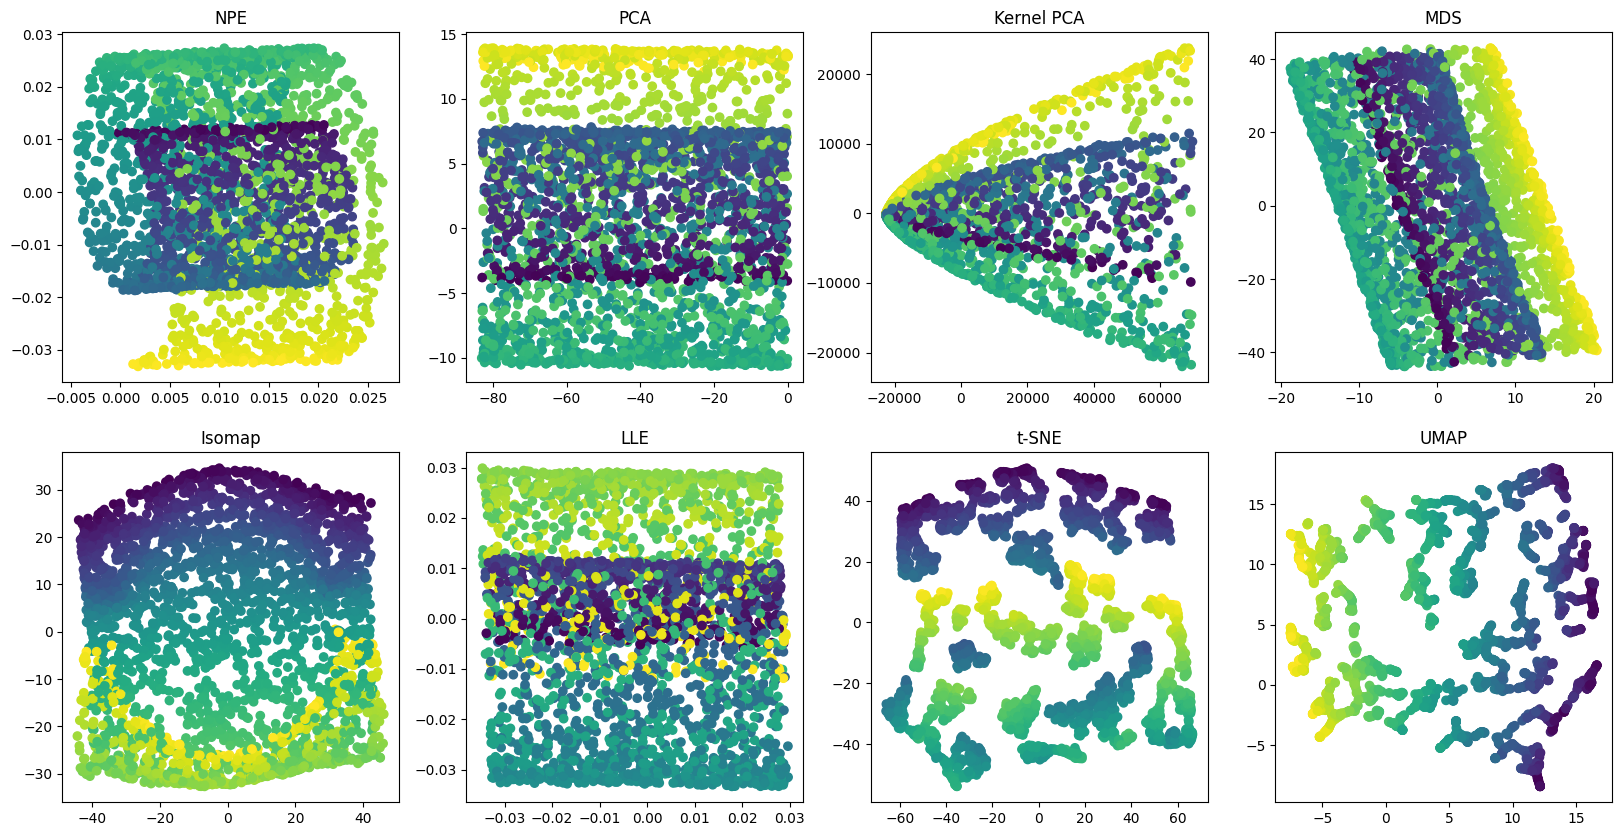

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for i, (transformation, name) in enumerate(zip(list_of_transformations, list_of_names)):
    axs[i].scatter(transformation[:, 0], transformation[:, 1], c=y)
    axs[i].set_title(name)

plt.show()
